# 강화 학습 맛보기

강화 학습 수업에 오신 여러분을 진심으로 환영합니다!

여러분이 앞으로 1년 동안 배우게 될 강화 학습은 인공지능 분야 중에서도 가장 독특하고 유용한 기술입니다.
아마 다른 어떤 수업에서도 경험하지 못할 재미있고 유익한 경험이 될 거에요.

## 강화 학습 내용 훑어보기

강화 학습은 시행착오를 거치며 경험을 통해 적절한 행동 방식을 배워나가는 과정입니다. "당근과 채찍" 전략을 생각하면 쉽습니다. 여러분이 좋은 행동을 하면 당근을, 나쁜 행동을 하면 채찍질을 주는 것이 바로 강화 학습입니다. 이 당근과 채찍을 통틀어 강화 학습에서는 "보상"이라고 부릅니다. 강화 학습의 가장 중요한 요소 중 하나가 바로 이 보상입니다.

![](https://s3-ap-northeast-2.amazonaws.com/opentutorials-user-file/module/4916/12365.jpeg)

강화 학습의 또 다른 중요한 요소는 바로 끊임없이 변화하는 환경의 상태입니다. 어러분이 취하는 행동은 여러분 주변의 환경을 변화시킵니다. 여러분은 이 끊임없이 변화하는 환경 속에서 계속 보상을 최대한 취할 수 있도록 노력해야합니다. 이 과정이 바로 강화 학습의 과정과 많이 닮아있습니다.



## 강화 학습 예제 경험하기

강화 학습이 어떤 문제를 풀 수 있는지 한번 살펴볼까요?

사실 강화 학습은 우리 주변에서 흔히 접할 수 있는 대부분의 문제를 다 풀 수 있는 아주 유용한 기술입니다. 로봇을 조종하는 것부터 시작해서, 자율 주행, 주식 투자, 심지어는 최근에 각광받는 ChatGPT 역시 강화 학습 기술이 사용되었습니다. 우리가 일상 생활에서 상벌의 개념을 생각할 수 있는 거의 모든 문제를 강화 학습으로 풀 수 있습니다.

In [3]:
%%capture
!pip install -U ray[rllib]
!pip install gputil
!pip install ipython==7.10.0
!pip install moviepy
!pip install gymnasium[classic-control]

In [4]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

import ray
import numpy as np
import gymnasium as gym

import warnings
warnings.filterwarnings('ignore')

from IPython.display import HTML
from base64 import b64encode
from gymnasium.wrappers import RecordVideo


def view_video(filename):
    video = f'video/{filename}-episode-0.mp4'
    mp4 = open(video,'rb').read()
    data_url = "data:video/mp4;base64," + b64encode(mp4).decode()

    return HTML("""
    <video width=400 controls>
          <source src="%s" type="video/mp4">
    </video>
    """ % data_url)

### 환경 정의하기

오늘 수업 시간에는 강화 학습에서 가장 단순하고 유명한 예제 중 하나인 "Mountain Car" 문제를 직접 풀어볼 것입니다. 이 문제에서 여러분의 목표는 산 정상의 깃발에 도달하는 것입니다.
여러분은 오른쪽 또는 왼쪽으로 가속하는 페달을 밟거나, 페달을 밟지 않는 선택을 할 수 있습니다.
산 정상까지 올라가려면 페달을 적절히 밟아야 합니다. 하지만 산의 경사가 너무 가파르기 때문에, 아무리 밟아도 중력 때문에 올라가지 못할 수도 있습니다.

![](https://www.gymlibrary.dev/_images/mountain_car.gif)

먼저, 이 환경에서 여러분이 취할 수 있는 행동은 다음과 같이 표현할 수 있습니다:

0: 왼쪽으로 가속하는 페달 밟기

1: 페달 밟지 않기

2: 오른쪽으로 가속하는 페달 밟기

In [5]:
env = gym.make('MountainCar-v0')
print('Created env:', env)
print('Available actions:', env.action_space) #행동의 ㄱ개수

Created env: <TimeLimit<OrderEnforcing<PassiveEnvChecker<MountainCarEnv<MountainCar-v0>>>>>
Available actions: Discrete(3)


다음으로, 이 환경에서 받을 수 있는 상태에 대한 정보는 $s_{t} = (x_{t}, v_{t})$입니다.
즉, 여러분이 받는 상태 정보 $s_{t}$는 $x$축 방향에서의 현재 위치 $x_{t}$와 속도 $v_{t}$입니다.

$x$축 방향의 좌표는 $(-1.2, 0.6)$ 사이이고, 속도 $v$는 (-0.07, 0.07) 사이입니다.

In [6]:
state, _ = env.reset()
print('Observation space:', env.observation_space) # == state
print('The starting state is:', state) # x축방향 위치, 속도

Observation space: Box([-1.2  -0.07], [0.6  0.07], (2,), float32)
The starting state is: [-0.48815003  0.        ]


여러분이 어떤 행동을 선택하면, 다음과 같이 환경의 상태가 변화합니다.

$v_{t+1} = v_{t} + (\mathrm{action} - 1) * F - \cos(3 * x_{t}) * mg$

$x_{t+1} = x_{t} + v_{t+1}$

여기서 $F$는 페달을 밟을 때 가속하는 힘 $F = 0.001$이고, 중력 $mg = 0.0025$입니다.

In [7]:
action = 0 # 왼쪽으로 가는 행동을 선택

# 행동 선택 후 다음 상태, 보상, 환경이 끝난지에 대한 정보, 뒤에 _ _는 지금 배우지 않음
state, reward, done, _, _ = env.step(action)
print(f"State: {state}") # [다음 x축 좌표, 다음 속도]
print(f"Reward: {reward}")# 다음 보상
print(f"Done: {done}") # 환경이 끝났는지?

State: [-0.48941538 -0.00126536]
Reward: -1.0
Done: False


### 인공지능 정책 정의하기

강화 학습에서 정책은 인공지능의 두뇌입니다. 인공지능이 변화하는 환경 속에서 어떻게 행동할지를 결정하는 지침으로 생각할 수 있습니다. 가장 단순한 형태의 정책으로는 여러분이 취할 수 있는 행동 중에서 아무거나 (샘플링하여) 고르는 것이 있겠습니다.

In [8]:
class RandomPolicy(): # 아무거나 하겠다
   # 클래스 선언
    def __init__(self, action_space):
      # 행동 공간에 대한 정보 저장
        self.action_space = action_space
        self.name="RandomPolicy()"

    # 클래스 호출 함수
    def __call__(self, state):
        global graph1
        graph1.append(state[1])
        # 상태 (state)를 받았을때 어떤 행동을 취할지 결정하는 함수
        # 여기선 랜덤한걸 선택
        return self.action_space.sample()

In [9]:
class ExamplePolicy():
    def __init__(self, action_space):
        self.action_space = action_space
        self.name="ExamplePolicy()"

        #새로정의하는 상수
        self.start_position=-0.6

    def __call__(self, state): # 밟는데 안움직이면 전환하는법
        global graph1
        graph1.append(state[1])
        x,v = state
        next_action=0
        if v ==0:
            if x < self.start_position:
                my_action=0
                next_action = 2
            elif x > self.start_position:
                my_action=2
                next_action = 0
            else:
                my_action=1
                next_action = 0

        return next_action

In [10]:
graph1=[]
graph2=[]
class Policy1():
    def __init__(self, action_space):
        self.action_space = action_space
        self.name="Policy1()"

    def __call__(self, state):
        global graph1
        global graph2
        graph1.append(state[1])
        graph2.append(state[0])

        x,v = state
        if v>0:
            action = 2
        elif v<0:
            action = 0
        else:
            action = 2
        return action

### 환경과 상호작용하기

정책이 있다면, 여러분은 주어진 상황에서 어떤 행동을 취해야 할지 결정할 수 있습니다. 그럼 이제 본격적으로 환경 속에 들어가서 직접 부딪혀볼까요?

여러분이 어떤 행동을 취하면, 환경은 여러분에게 보상을 줍니다. 이 보상은 여러분이 좋은 행동을 했는지, 나쁜 행동을 했는지 알려주는 값입니다. 그리고 여러분이 취한 행동에 따라 환경은 변화하고, 이 변화한 환경을 여러분은 다시 관찰할 수 있습니다. 그리고 여러분은 또다시 (여러분이 관찰한 결과를 토대로) 어떤 행동을 취할지 결정합니다. 강화 학습은 이 과정을 반복하며 진행됩니다.

In [11]:
import matplotlib.pyplot as plt
import numpy as np

In [12]:
# 환경을 생성
env = gym.make("MountainCar-v0", render_mode="rgb_array")
# 비디오 저장을 위해
env = RecordVideo(env, 'video', name_prefix='random-agent')

#정책 불러오기
# agent = RandomPolicy(env.action_space)
agent = Policy1(env.action_space)
# agent = ExamplePolicy(env.action_space)

state, _ = env.reset()# 환경 초기화
env.start_video_recorder() # 비디오 촬영 시작

graph1=[]
graph2=[]
done=False
# for t in range(1000):
while not done:
    action = agent(state) # 상태정보를 받아 행동 결정
    state, reward, done, _, _ = env.step(action) # 행동에 의해 상태 변화
    env.render() # 비디오 촬영

env.close()
view_video('random-agent')

Moviepy - Building video /content/video/random-agent-episode-0.mp4.
Moviepy - Writing video /content/video/random-agent-episode-0.mp4



Moviepy - Done !
Moviepy - video ready /content/video/random-agent-episode-0.mp4


Moviepy - Building video /content/video/random-agent-episode-0.mp4.
Moviepy - Writing video /content/video/random-agent-episode-0.mp4



Moviepy - Done !
Moviepy - video ready /content/video/random-agent-episode-0.mp4


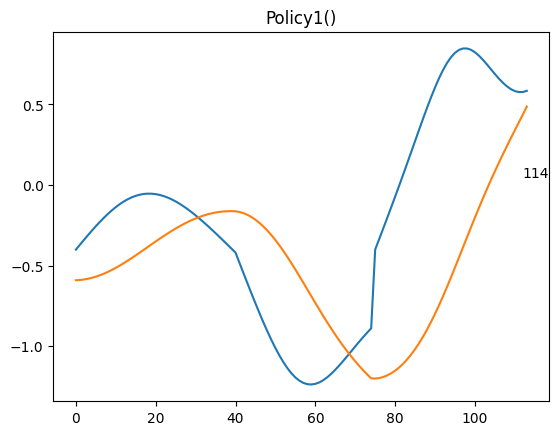

In [13]:
plt.title(agent.name)
# print(len(graph1))
plt.text(len(graph1)-2, graph1[-1], str(len(graph1)))
plt.plot([i for i in range(len(graph1))], list(map(lambda x: x*20-0.4, graph1)))
plt.plot([i for i in range(len(graph2))], graph2)

### BONUS: 강화 학습 에이전트 학습하기

In [14]:
%%capture
from ray.rllib.algorithms.ppo import PPOConfig
from ray.tune.logger import pretty_print

algo = (
    PPOConfig()
    .rollouts(num_rollout_workers=1)
    .resources(num_gpus=1)
    .environment(env="MountainCar-v0")
    .build()
)

for i in range(2):
    algo.train()

KeyboardInterrupt: 

In [15]:
env = gym.make("MountainCar-v0", render_mode="rgb_array")
env = RecordVideo(env, 'video', name_prefix='ppo-agent')

state, _ = env.reset()
env.start_video_recorder()

for t in range(1000):
    action = algo.compute_single_action(state)
    state, reward, done, _, _ = env.step(action)
    env.render()

env.close()
view_video('ppo-agent')

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Moviepy - Building video /content/video/ppo-agent-episode-0.mp4.
Moviepy - Writing video /content/video/ppo-agent-episode-0.mp4



Moviepy - Done !
Moviepy - video ready /content/video/ppo-agent-episode-0.mp4


NameError: name 'algo' is not defined

# 강화 학습 환경 직접 만져보기

### 블랙잭

In [56]:
end=0
number1=50000
for i in range(number1):
    # 블랙잭 환경 생성
    env = gym.make('Blackjack-v1')

    # 환경 초기화
    state, _ = env.reset()
    # print(f"초기 상태: {state}")

    done = False
    while not done:
        # 랜덤 행동 선택 (for 루프 사용하지 않음)
        action = Policy1(state)
        # print(f"액션: {action}")

        # 환경에서 행동 수행
        state, reward, done, info, _ = env.step(action)

        # 현재 상태, 보상, 게임 종료 여부 출력
        # print('상태:', state,'보상:', reward, '게임 종료:', done)

    # 환경 닫기
    env.close()
    if done:
        if reward==1.0:
            end+=1
    # print("="*20)
print(f"{number1} 실행 후 {end}번 승리, 승률 {end/number1}")

50000 실행 후 19597번 승리, 승률 0.39194


In [52]:
import random

def Policy1(state):
    currentSum, dealer, ace=state
    rand1=random.randint(1, 12)
    if rand1==12:
        if currentSum==21:
            action=0
        else: action=1
    elif currentSum>8 and currentSum<12:
        if currentSum<12:
            action=1
        else: action=0
    elif currentSum+rand1<21:
        action=1
    else:
        action=0

    return action


### Tic-Tac-Toe

In [ ]:
import numpy as np
import gymnasium as gym
from gymnasium import spaces

class TicTacToeEnv(gym.Env):
    def __init__(self):
        self.board = np.zeros((3, 3), dtype=int)
        self.current_player = 1
        self.action_space = spaces.Discrete(9)
        self.observation_space = spaces.Box(low=0, high=1, shape=(3, 3), dtype=int)

    def reset(self):
        self.board = np.zeros((3, 3), dtype=int)
        self.current_player = 1
        return self.board

    def step(self, action):
        row = action // 3
        col = action % 3

        if self.board[row, col] != 0:
            return self.board, -1, False, False, {}

        self.board[row, col] = self.current_player

        if self._check_winner(self.current_player):
            return self.board, 1, True, False, {}

        if np.count_nonzero(self.board) == 9:
            return self.board, 0, True, False, {}

        self.current_player = -self.current_player
        return self.board, 0, False, False, {}

    def render(self):
        print(self.board)

    def _check_winner(self, player):
        for i in range(3):
            if np.all(self.board[i, :] == player) or np.all(self.board[:, i] == player):
                return True
        if np.all(np.diag(self.board) == player) or np.all(np.diag(np.fliplr(self.board)) == player):
            return True
        return False

In [ ]:
class Policy1():
    def __init__(self, action_space):
        self.action_space = action_space
        self.name="Policy1()"

    def __call__(self, state):

        return state

In [ ]:
env = TicTacToeEnv()
state = env.reset()
env.render()
import random

done = False
# while not done:
for i in range(9):
    action = random.randint(1,10)
    state, reward, done, _, _ = env.step(action)
    env.render()